In [1]:
import psutil
def get_size(bytes, suffix="B"):
    factor = 1024
    for unit in ["", "K", "M", "G", "T", "P"]:
        if bytes < factor:
            return f"{bytes:.2f}{unit}{suffix}"
        bytes /= factor
print("="*40, "Memory Information", "="*40)
svmem = psutil.virtual_memory()
print(f"Total: {get_size(svmem.total)}") ; print(f"Available: {get_size(svmem.available)}")
print(f"Used: {get_size(svmem.used)}") ; print(f"Percentage: {svmem.percent}%")


======================================== Memory Information ========================================
Total: 15.36GB
Available: 7.69GB
Used: 7.68GB
Percentage: 50.0%


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
#!pip install torchtext==0.6.0
from torchtext.data.metrics import bleu_score

#from torchtext.datasets import Multi30k
from torchtext.datasets import WMT14,Multi30k
from torchtext.data import Field, BucketIterator

import spacy
import numpy as np

import random
import math
import time

import matplotlib.pyplot as plt

In [3]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

!python -m spacy download en
!python -m spacy download de

spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

You should consider upgrading via the 'C:\Users\91771\AppData\Local\Programs\Python\Python38\python.exe -m pip install --upgrade pip' command.
You do not have sufficient privilege to perform this operation.
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✘ Couldn't link model to 'en'
Creating a symlink in spacy/data failed. Make sure you have the required
permissions and try re-running the command as admin, or use a virtualenv. You
can still import the model as a module and call its load() method, or create the
symlink manually.
C:\Users\91771\AppData\Local\Programs\Python\Python38\lib\site-packages\en_core_web_sm
-->
C:\Users\91771\AppData\Local\Programs\Python\Python38\lib\site-packages\spacy\data\en
⚠ Download successful but linking failed
Creating a shortcut link for 'en' didn't work (maybe you don't have admin
permissions?), but you can still load the model via its full package name: nlp =
spacy.load('en_core_web_sm')
✔ Download a

In [4]:
def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings
    """
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

SRC = Field(tokenize = tokenize_de, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            include_lengths = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

In [5]:
train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), fields = (SRC, TRG))

def partial_shuffle(data):
    M = data.shape[1]
    data = data.t()
    N = data.shape[0] # batch size
    splits = torch.from_numpy(np.random.randint(M, size=N))
    shifted = []
    for i, row in enumerate(data):
        shifted.append(torch.cat((row[splits[i]:], row[:splits[i]])))
    return torch.stack(shifted).t()

#train_data = np.fromiter(train_data,'<U256')
#train_data = np.array(list(train_data))
#print(train_data)
#train_data = partial_shuffle(train_data)
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

BATCH_SIZE = 128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [6]:
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     sort_within_batch = True,
     sort_key = lambda x : len(x.src),
     device = device)

class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_len):
        
        #src = [src len, batch size]
        #src_len = [batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
                
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, src_len.cpu())
                
        packed_outputs, hidden = self.rnn(packed_embedded)
                                 
        #packed_outputs is a packed sequence containing all hidden states
        #hidden is now from the final non-padded element in the batch
            
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs) 
            
        #outputs is now a non-packed sequence, all hidden states obtained
        #  when the input is a pad token are all zeros
            
        #outputs = [src len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]
        
        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer
        
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN
        
        #initial decoder hidden is final hidden state of the forwards and backwards 
        #  encoder RNNs fed through a linear layer
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        epsilon = 0.005 
        hidden = hidden + epsilon*torch.rand(hidden.shape[0],hidden.shape[1]).to(device)
        #outputs = [src len, batch size, enc hid dim * 2]
        #hidden = [batch size, dec hid dim]
        
        return outputs, hidden

class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs, mask):
        
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #repeat decoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
  
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #hidden = [batch size, src len, dec hid dim]
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        
        #energy = [batch size, src len, dec hid dim]

        attention = self.v(energy).squeeze(2)
        
        #attention = [batch size, src len]
        
        attention = attention.masked_fill(mask == 0, -1e10)
        T = 1000
        # T = 1
        return F.softmax(attention/T, dim = 1)

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention
        self.fc_noise = nn.Linear(2*enc_hid_dim,output_dim)
        if self.attention is not None:
            self.embedding = nn.Embedding(output_dim, emb_dim)
            
            self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
            
            self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
            
            self.dropout = nn.Dropout(dropout)
        else:
            self.embedding = nn.Embedding(output_dim, emb_dim)
            self.rnn = nn.GRU(emb_dim, dec_hid_dim)
            self.fc_out = nn.Linear(dec_hid_dim + emb_dim, output_dim)
            self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs, mask):
             
        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        #mask = [batch size, src len]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
        if self.attention == None:
            rnn_input = embedded
            output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
            assert (output == hidden).all()
            
            embedded = embedded.squeeze(0)
            output = output.squeeze(0)
            latent=torch.cat((output, embedded), dim = 1)
            prediction = self.fc_out(torch.cat((output,embedded), dim = 1))
            return prediction, hidden.squeeze(0), hidden.squeeze(0)
        else:
            a = self.attention(hidden, encoder_outputs, mask)

            #a = [batch size, src len]
            
            a = a.unsqueeze(1)
            
            #a = [batch size, 1, src len]
            
            encoder_outputs = encoder_outputs.permute(1, 0, 2)
            
            #encoder_outputs = [batch size, src len, enc hid dim * 2]
            
            weighted = torch.bmm(a, encoder_outputs)
            
            #weighted = [batch size, 1, enc hid dim * 2]
            
            weighted = weighted.permute(1, 0, 2)
            
            #weighted = [1, batch size, enc hid dim * 2]
            
            rnn_input = torch.cat((embedded, weighted), dim = 2)
            
            #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]
                
            output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
            
            #output = [seq len, batch size, dec hid dim * n directions]
            #hidden = [n layers * n directions, batch size, dec hid dim]
            
            #seq len, n layers and n directions will always be 1 in this decoder, therefore:
            #output = [1, batch size, dec hid dim]
            #hidden = [1, batch size, dec hid dim]
            #this also means that output == hidden
            assert (output == hidden).all()
            
            embedded = embedded.squeeze(0)
            output = output.squeeze(0)
            weighted = weighted.squeeze(0)

            latent=torch.cat((output, weighted, embedded), dim = 1)
            
            prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))

            #targets=targets.view([-1,1]).expand([-1,____]).contiguous().view(-1)
            # weight_noise=torch.zeros_like(self.fc_out.weight).cuda()
            # neg_h=-latent/torch.sqrt(torch.sum(latent**2,1,keepdim=True)+1e-8)
            # n_output=torch.sqrt(torch.sum(latent**2,1,keepdim=True)+1e-8)
            # #n_w= 
            # #cos_theta = 
            # indicator=torch.gt(cos_theta,0e-1).view(-1,1).type(torch.cuda.FloatTensor)
            # epsilon=0.005
            # sigma=epsilon*n_w*indicator
            # weight_noise[targets.view(-1)]=sigma.detach()*neg_h.detach()
            # noise_outputs=(latent*weight_noise[targets]).sum(1)
            # prediction[torch.arange(targets.size(0)).long().cuda(),targets]+=noise_outputs
            # epsilon = 0.005
            # #prediction = [batch size, output dim]
            # noise = epsilon*self.fc_noise(weighted)
            # prediction = prediction + noise 
            return prediction, hidden.squeeze(0), a.squeeze(1)

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.device = device
        
    def create_mask(self, src):
        mask = (src != self.src_pad_idx).permute(1, 0)
        return mask
        
    def forward(self, src, src_len, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #src_len = [batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
                    
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src, src_len)
                
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        mask = self.create_mask(src)

        #mask = [batch size, src len]
                
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden state, all encoder hidden states 
            #  and mask
            #receive output tensor (predictions) and new hidden state
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs, mask)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1
            
        return outputs

In [7]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)
# dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, None)

model = Seq2Seq(enc, dec, SRC_PAD_IDX, device).to(device)

def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

optimizer = optim.Adam(model.parameters())

TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)


The model has 26,558,986 trainable parameters


In [8]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):

    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('de')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)

    src_len = torch.LongTensor([len(src_indexes)]).to(device)
    
    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor, src_len)

    mask = model.create_mask(src_tensor)
        
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    attentions = torch.zeros(max_len, 1, len(src_indexes)).to(device)
    
    for i in range(max_len):

        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
                
        with torch.no_grad():
            output, hidden, attention = model.decoder(trg_tensor, hidden, encoder_outputs, mask)

        # attentions[i] = attention
            
        pred_token = output.argmax(1).item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attentions[:len(trg_tokens)-1]

In [9]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src, src_len = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, src_len, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    model.eval()
    
    epoch_loss = 0
    example_idx = 12
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):
            if i==example_idx:
                src, src_len = batch.src
                trg = batch.trg
                print(f'src = {src}')
                print(f'trg = {trg}')
                translation, attention = translate_sentence(src, SRC, TRG, model, device)
                print(f'predicted trg = {translation}')
            src, src_len = batch.src
            trg = batch.trg

            output = model(src, src_len, trg, 0) #turn off teacher forcing
            
            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [10]:
def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)


In [11]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')
bleu_score_list = []
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    # if valid_loss < best_valid_loss:
    #     best_valid_loss = valid_loss
    #     torch.save(model.state_dict(), 'tut4-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    bleu_score2 = calculate_bleu(test_data, SRC, TRG, model, device)
    bleu_score_list.append(bleu_score2)

#model.load_state_dict(torch.load('nlp_proj.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')



Epoch: 01 | Time: 0m 52s
	Train Loss: 5.054 | Train PPL: 156.686
	 Val. Loss: 4.787 |  Val. PPL: 119.966
Epoch: 02 | Time: 0m 51s
	Train Loss: 4.186 | Train PPL:  65.748
	 Val. Loss: 4.351 |  Val. PPL:  77.591
Epoch: 03 | Time: 0m 51s
	Train Loss: 3.602 | Train PPL:  36.686
	 Val. Loss: 3.993 |  Val. PPL:  54.222
Epoch: 04 | Time: 0m 51s
	Train Loss: 3.163 | Train PPL:  23.651
	 Val. Loss: 3.710 |  Val. PPL:  40.843
Epoch: 05 | Time: 0m 50s
	Train Loss: 2.775 | Train PPL:  16.046
	 Val. Loss: 3.512 |  Val. PPL:  33.517
Epoch: 06 | Time: 0m 51s
	Train Loss: 2.478 | Train PPL:  11.919
	 Val. Loss: 3.470 |  Val. PPL:  32.132
Epoch: 07 | Time: 0m 50s
	Train Loss: 2.208 | Train PPL:   9.099
	 Val. Loss: 3.415 |  Val. PPL:  30.418
Epoch: 08 | Time: 0m 52s
	Train Loss: 1.990 | Train PPL:   7.317
	 Val. Loss: 3.398 |  Val. PPL:  29.918
Epoch: 09 | Time: 0m 51s
	Train Loss: 1.804 | Train PPL:   6.072
	 Val. Loss: 3.446 |  Val. PPL:  31.360
Epoch: 10 | Time: 0m 52s
	Train Loss: 1.681 | Train PPL

In [12]:
print(bleu_score_list)

[0.03323553584133831, 0.05812844697892875, 0.11240297388363661, 0.15551539536785797, 0.19207579264301675, 0.2158014914180768, 0.23518141187294409, 0.23788576730473643, 0.2500137388706207, 0.24551904061495625]


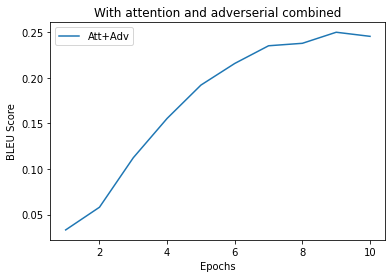

In [13]:
f = plt.figure()
plt.plot(range(1,11),bleu_score_list,label="Att+Adv")
plt.xlabel("Epochs")
plt.ylabel("BLEU Score")
plt.legend()
plt.title("With attention and adverserial combined")
plt.savefig('attention-adverserial.png')


In [14]:
example_idx = 13

# src = vars(train_data.examples[example_idx])['src']
# trg = vars(train_data.examples[example_idx])['trg']
src = "guter Junge".split(" ")
trg = "A man in an orange hat starring at something.".split(" ")

print(f'src = {src}')
print(f'trg = {trg}')

translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

#display_attention(src, translation, attention)



#print(f'BLEU score = {bleu_score*100:.2f}')

src = ['guter', 'Junge']
trg = ['A', 'man', 'in', 'an', 'orange', 'hat', 'starring', 'at', 'something.']
predicted trg = ['young', 'boy', 'is', 'swimming', '.', '<eos>']


In [15]:
print(f'BLEU score = {bleu_score2*100:.2f}')

BLEU score = 24.55


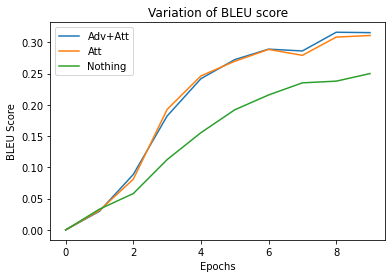

In [18]:
fig = plt.figure()
adv_att = [0, 0.029847215696862498, 0.08871566321754082, 0.18212572484584194, 0.24186216404608932, 0.27230911505108274, 0.28904786705970764, 0.28619252623998076, 0.3160997648238185, 0.31546737346277787]
att = [0, 0.03105821514994027, 0.08108653435804296, 0.19269258631544273, 0.246329438747153, 0.26966697612763507, 0.2886365711183409, 0.27918667003426206, 0.3083132972791218, 0.3109098321290997]
bl = [0, 0.03323553584133831, 0.05812844697892875, 0.11240297388363661, 0.15551539536785797, 0.19207579264301675, 0.2158014914180768, 0.23518141187294409, 0.23788576730473643, 0.2500137388706207]
plt.plot(range(0,10),adv_att,label="Adv+Att")
plt.plot(range(0,10),att,label="Att")
plt.plot(range(0,10),bl,label="Nothing")
plt.xlabel("Epochs")
plt.ylabel("BLEU Score")
plt.legend()
plt.title("Variation of BLEU score")
plt.savefig('attention-adverserial.png')